# Signate開始時のお約束

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=fecdbe8eab0cb69f1603c066535a95822204b6c20200fdb831a50f80370fb3d7
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [ ]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [ ]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [ ]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [ ]:
!pip install kanjize

In [ ]:
# "Age"の処理
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で保管
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

In [ ]:
# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

<ipython-input-141-20d47ff9ceed>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


In [ ]:
# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

In [ ]:
# "TypeofContakt"の処理
# 個人/法人の2択のためホットエンコードにする
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4444
Company Invited,2516


In [ ]:
# 取り除く変数
RMV = ["id","ProdTaken"]

# 使用する変数を制限
FEATURES = ["Age","TypeofContact","CityTier","NumberOfPersonVisiting","NumberOfFollowups","PreferredPropertyStar",
         "Passport","PitchSatisfactionScore","ProdTaken"]

TARGET = "ProdTaken"

In [ ]:
# 現状のカラム
# FEATURES = [c for c in all_df.columns if not c in RMV]

In [ ]:
# カテゴリ変数の分類
# CATS = []
# for c in FEATURES:
#   if all_df[c].dtype == "object":
#     CATS.append(c)

CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [ ]:
# カラムを制限
all_df2 = all_df[FEATURES]

all_df2 = pd.get_dummies(all_df2, columns=CATS)

# 特徴量の整理
# for c in FEATURES:

#   # カテゴリ変数の場合はラベルエンコード
#   for c in CATS:
#     all_df2 = pd.get_dummies(all_df2, columns=c)

  # 数値の場合はメモリを減らす
  # else:
  #   if all_df2[c].dtype == "float64":
  #     all_df2[c] = all_df2[c].astype("float32")
  #   if all_df2[c].dtype == "int64":
  #     all_df2[c] = all_df2[c].astype("int32")

In [ ]:
# # 使用する説明変数を抽出
# param = ["Age","TypeofContact","CityTier","NumberOfPersonVisiting","NumberOfFollowups","PreferredPropertyStar",
#          "Passport","PitchSatisfactionScore","ProdTaken"]

# all_df2 = all_df[param]

In [ ]:
# # ダミー変数をかける
# dummy_col = ["TypeofContact"]

# all_df2 = pd.get_dummies(all_df2, columns=dummy_col)

In [ ]:
# # 特徴量を分類
# # 全パラメータ
# param = ["id","Age","TypeofContact","CityTier","DurationOfPitch","Occupation","Gender",
#          "NumberOfPersonVisiting","NumberOfFollowups","ProductPitched","PreferredPropertyStar",
#          "NumberOfTrips","Passport","PitchSatisfactionScore","Designation","MonthlyIncom","customer_info"]

# # 数値データ
# param_num = ["Age","TypeofContact","CityTier","NumberOfPersonVisiting","NumberOfFollowups","PreferredPropertyStar",
#          "Passport","PitchSatisfactionScore"]

# # カテゴリデータ
# param_cat = ["id","DurationOfPitch","Occupation","Gender",
#          "NumberOfTrips","ProductPitched","Designation","customer_info","MonthlyIncome"]

# # param_cat = ["id","TypeofContact","DurationOfPitch","Occupation","Gender",
# #          "NumberOfTrips","ProductPitched","Designation","customer_info","MonthlyIncome"]

In [ ]:
# カテゴリデータ
# RMV = ["id","DurationOfPitch","Occupation","Gender",
#         "NumberOfTrips","ProductPitched","Designation","customer_info","MonthlyIncome"]

# FEATURE = ["Age","TypeofContact","CityTier","NumberOfPersonVisiting","NumberOfFollowups","PreferredPropertyStar",
#          "Passport","PitchSatisfactionScore"]

# TARGET = "ProdTaken"

In [ ]:
# # 現状カラム列挙
# allcol = all_df2.columns

# # 全カラム
# cols = []

# # 不要なカラムを取り除く
# for name in cols:
#   if(name not in RMV):
#     cols.append(name)

# # 説明カラム
# col = []

# # 説明カラム
# for name in cols:
#   if(name not in TARGET):
#     col.append(name)

In [ ]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

In [ ]:
train

,Age,CityTier,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken,TypeofContact_Company Invited,TypeofContact_Self Enquiry
0,50,2,1.0,4.0,3.0,1,4,1.0,False,True
1,56,1,1.0,4.0,3.0,1,4,0.0,True,False
2,38,1,1.0,3.0,3.0,0,4,1.0,False,True
3,37,2,1.0,3.0,4.0,0,5,0.0,False,True
4,48,3,1.0,3.0,4.0,0,4,1.0,True,False
...,...,...,...,...,...,...,...,...,...,...
3484,40,2,2.0,3.0,3.0,0,1,1.0,False,True
3485,45,1,3.0,3.0,5.0,0,3,0.0,False,True
3486,31,1,3.0,2.0,3.0,0,4,0.0,False,True
3487,56,2,3.0,6.0,3.0,1,4,1.0,True,False


In [ ]:
# 対象の列のみ取り込み
# train = train.drop(param_cat,axis=1)
# test = test.drop(param_cat,axis=1)
test = test.drop(TARGET,axis=1)

In [ ]:
FEATURES = test.columns

In [ ]:
# import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
# from xgboost import XGBRegressor, XGBClassifier
# import xgboost
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'regression',
    # "device": "cuda",
    "device": "cpu",
    'metric': 'rmse',
    'boosting_type': 'gbdt',    # BoostingのType
    'num_leaves': 63,           # 葉の数　default = 31,
    'learning_rate': 0.01,       # 学習率　default = 0.1
    'feature_fraction': 0.8,    # 特徴量側のサンプリング　default = 1.0
    'bagging_freq': 5,          # Baggingを何回に1回行うか　default = 0
    'bagging_fraction': 0.8,    # サンプル側のサンプリング　default = 1.0
    # 'num_boost_round': 6000,
    'random_state': 42,
    # 'max_depth': -1,          # 木の深さ（デフォルトは無制限）
    'verbose': -1              # ログ出力の制御
    }

In [ ]:
%%time

FOLDS = 3 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's rmse: 0.319368	valid's rmse: 0.328821
[200]	train's rmse: 0.305518	valid's rmse: 0.325706
[300]	train's rmse: 0.296676	valid's rmse: 0.325836
#########################
### Fold 2
#########################
[100]	train's rmse: 0.30845	valid's rmse: 0.349137
[200]	train's rmse: 0.293781	valid's rmse: 0.34708
#########################
### Fold 3
#########################
[100]	train's rmse: 0.323611	valid's rmse: 0.319322
[200]	train's rmse: 0.308544	valid's rmse: 0.317781
[300]	train's rmse: 0.297938	valid's rmse: 0.319193
CPU times: user 11.2 s, sys: 145 ms, total: 11.4 s
Wall time: 1.44 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.7226359493861565


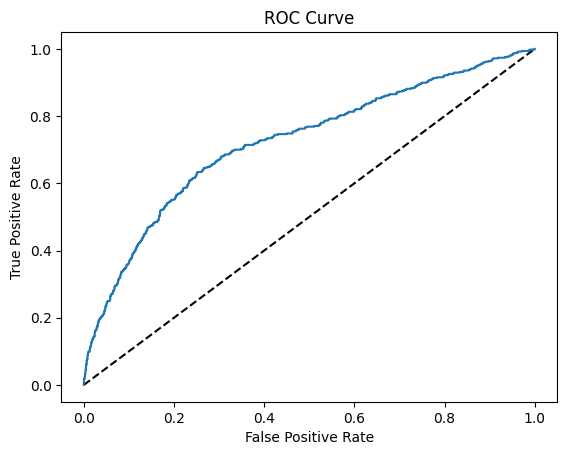

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [ ]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [ ]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)